# Create a Gesture database

In [1]:
# Requirements
import numpy as np
import os, cv2

# Constants
image_x, image_y = 50, 50

In [2]:
# Utility finctions
def create_folder(folder_name):
    "Create folder if does not exist"
    if not os.path.exists(folder_name):
        #os.mkdir(folder_name)
        try:
            os.makedirs(folder_name)
        except OSError as exc: 
            if exc.errno == errno.EEXIST and os.path.isdir(path):
                pass
            else:
                raise

def show_img(img, title="", delay=4000):
    cv2.imshow(title,img)
    cv2.waitKey(delay)
    cv2.destroyAllWindows()
        

def main(gesture_id):
    # Open the default Camera
    cap = cv2.VideoCapture(0)
    
    total_pics = 2000
    # # ROI (Region of interest)
    x, y, w, h = 300, 50, 350, 350
    flag_start_capturing = False
    pic_no, frames = (0, 0)
    
    # Create a folder for the gesture
    create_folder('gestures/' + str(gesture_id))
    
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        # Vertical flip the frame
        frame = cv2.flip(frame, 1)
        
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Checks if array elements lie between the elements of two other arrays.
        mask = cv2.inRange(hsv, np.array([2, 50, 60]), np.array([25, 150, 255]))
        # extracts the mask area from the original frame
        res = cv2.bitwise_and(frame, frame, mask=mask)
        gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
        median = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Dilates the image using a squared_kernel
        kernel_square = np.ones((5,5), np.uint8)
        dilation = cv2.dilate(median, kernel_square, iterations=2)
        # Dilation followed by Erosion. -> closing small holes
        opening = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel_square)
        
        # thresholding, grayscale to binary image
        ret, thresh = cv2.threshold(opening, 30, 255, cv2.THRESH_BINARY)
        # Crop the image to get the area of interest
        thresh = thresh[y:y+h, x:x+w]
        
        # cv2.RETR_TREE, retrieves all the contours and full hierarchy list.
        # cv2.CHAIN_APPROX_NONE, all the boundary points are stored.
        contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[1]
        
        if len(contours) > 0:
            # find contour that delimit the largest area
            contour = max(contours, key=cv2.contourArea)
            # If big area, start saving gestures after frame 20
            if cv2.contourArea(contour) > 10000 and frames > 20:
                x1, y1, w1, h1 = cv2.boundingRect(contour)
                pic_no += 1
                # Crop the image to the boundingRect
                save_img = thresh[y1:y1+h1, x1:x1+w1]
                
                gray[y+y1:y+h+y1]
                
                # Add black border to src, (top, bottom, left, right, borderType)
                if w1 > h1:                    
                    save_img = cv2.copyMakeBorder(save_img, (w1 - h1)//2, (w1 - h1)//2, 0, 0, cv2.BORDER_CONSTANT, (0,0,0))
                elif h1 > w1:
                    save_img = cv2.copyMakeBorder(save_img, 0, 0, (h1 - w1)//2, (h1 - w1)//2, cv2.BORDER_CONSTANT, (0,0,0))
                
                save_img = cv2.resize(save_img, (image_x, image_y))
                
                # img, text, org(Bottom-left corner), fontFace, fontScale, color
                cv2.putText(frame, 'Capturing...', (30, 60), cv2.FONT_HERSHEY_TRIPLEX, 2, (127, 255, 255))
                
                # Save the image
                cv2.imwrite("gestures/" + str(gesture_id) + "/" + str(pic_no) + ".jpg", save_img)
        
        ## Create two windows, the first shows the frame with green reclangle and pic_no
        # and the second shows the threshold image
        
        # Draw a rectangle: img, pt1, pt2, color, thickness
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, str(pic_no), (30, 400), cv2.FONT_HERSHEY_TRIPLEX, 1.5, (127, 127, 255))
        cv2.imshow("Capturing gesture", frame)
        cv2.imshow("thresh", thresh)
        
        # Waits for the user input key (1s)
        keypress = cv2.waitKey(1)
        if keypress == ord('c'):
            if flag_start_capturing == False:
                flag_start_capturing = True
            else:
                flag_start_capturing = False
                frames = 0
        if flag_start_capturing == True:
            frames += 1
        if pic_no == total_pics:
            cv2.destroyAllWindows()
            break

In [55]:
# Repeat this for all the gestures
g_id = input("Enter a gesture number: ")
main(g_id)

Enter a gesture number: 5


# Data Preparation

In [7]:
from keras.utils import Sequence
import pandas as pd

DATA_DIR = "gestures"
CATEGORIES = os.listdir(DATA_DIR)
Ncategories = len(CATEGORIES)
seed = 100

labels_df = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(DATA_DIR, category)):
        labels_df.append(['{}/{}/{}'.format(DATA_DIR, category, file), 
                          category, category_id])
labels_df = pd.DataFrame(labels_df, columns=['Img_path', 'Category', 'Category_id'])

labels_df.sample(n=6, random_state=seed)

,Img_path,Category,Category_id
8018,gestures/5/1014.jpg,5,4
9225,gestures/5/300.jpg,5,4
3854,gestures/2/868.jpg,2,1
2029,gestures/2/1024.jpg,2,1
3539,gestures/2/584.jpg,2,1
1942,gestures/1/947.jpg,1,0


In [8]:
# Data generator 
class data_generator(Sequence):
    
    def create_train(dataset, batch_size, shape, augment=True):
        assert shape == (50, 50)
        while True:
            dataset = shuffle(dataset)
            for start in range(0, dataset.shape[0], batch_size):
                end = min(start + batch_size, dataset.shape[0])
                batch_images = []
                X_train_batch = dataset.iloc[start:end, :]
                batch_labels = np.zeros((X_train_batch.shape[0], Ncategories))
                for i in range(X_train_batch.shape[0]):
                    image = data_generator.load_image( X_train_batch.iloc[i, 0])
                    
                    batch_images.append(image)
                    # OneHotEncode Category_id
                    batch_labels[i][X_train_batch.iloc[i, 2]] = 1
                    
                yield np.array(batch_images, np.float32), batch_labels
                
    def create_valid(dataset, batch_size, shape, augment=False):
        assert shape == (50, 50)
        while True:
            # dataset = shuffle(dataset)
            for start in range(0, dataset.shape[0], batch_size):
                end = min(start + batch_size, dataset.shape[0])
                batch_images = []
                X_valid_batch = dataset.iloc[start:end, :]
                batch_labels = np.zeros((X_valid_batch.shape[0], Ncategories))
                for i in range(X_valid_batch.shape[0]):
                    image = data_generator.load_image( X_valid_batch.iloc[i, 0])
                    
                    batch_images.append(image)
                    # OneHotEncode Category_id
                    batch_labels[i][X_valid_batch.iloc[i, 2]] = 1
                    
                yield np.array(batch_images, np.float32), batch_labels
                
    def load_image(path):
        image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=-1)
        return image

## Splitting Data

In [9]:
from sklearn.model_selection import train_test_split

train, valid, _, _ = train_test_split(labels_df, labels_df.iloc[:,-1], 
                                      stratify = labels_df.iloc[:,-1], 
                                      test_size=0.15, random_state=seed)
# Model Hyperparameters
Batch_size, Nepochs = 50, 15

train_gen = data_generator.create_train(train, Batch_size, (50, 50))
val_gen = data_generator.create_valid(valid, Batch_size, (50, 50))

# Classification Model

In [10]:
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
import keras.backend as K

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [11]:
# Check if keras(>=2.1.1) is using GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [12]:
def keras_model(image_x, image_y):
    '''Create a keras model.'''
    num_of_classes = 12
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(image_x, image_y, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(64, (3, 3), activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=(5, 5), strides=(5, 5), padding='same'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(Ncategories, activation='softmax'))

    return model

# Create model
model = keras_model(50, 50)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Creating callbacks
filepath = os.path.join('checkpoint', 'Myemojinator.h5')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduceLROnPlat = ReduceLROnPlateau( monitor='val_acc', factor=0.2, patience=5, 
                                    verbose=1, mode='max', cooldown=2, min_lr=1e-7 )
callbacks_list = [checkpoint, reduceLROnPlat]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               819712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
__________

In [62]:
# Training the model
history = model.fit_generator(
    generator = train_gen,
    steps_per_epoch = train.shape[0]//Batch_size,
    validation_data = val_gen,
    validation_steps = valid.shape[0]//Batch_size,
    epochs = Nepochs,
    callbacks = callbacks_list
)

Epoch 1/15
170/170 [==============================] - 215s 1s/step - loss: 0.4309 - acc: 0.8702 - val_loss: 0.1123 - val_acc: 0.9713

Epoch 00001: val_acc improved from -inf to 0.97133, saving model to emojinator.h5
Epoch 2/15
170/170 [==============================] - 212s 1s/step - loss: 0.0733 - acc: 0.9814 - val_loss: 0.0594 - val_acc: 0.9833

Epoch 00002: val_acc improved from 0.97133 to 0.98333, saving model to emojinator.h5
Epoch 3/15
170/170 [==============================] - 212s 1s/step - loss: 0.0516 - acc: 0.9860 - val_loss: 0.0358 - val_acc: 0.9873

Epoch 00003: val_acc improved from 0.98333 to 0.98733, saving model to emojinator.h5
Epoch 4/15
170/170 [==============================] - 212s 1s/step - loss: 0.0431 - acc: 0.9886 - val_loss: 0.0254 - val_acc: 0.9920

Epoch 00004: val_acc improved from 0.98733 to 0.99200, saving model to emojinator.h5
Epoch 5/15
170/170 [==============================] - 213s 1s/step - loss: 0.0304 - acc: 0.9915 - val_loss: 0.0506 - val_acc: 0

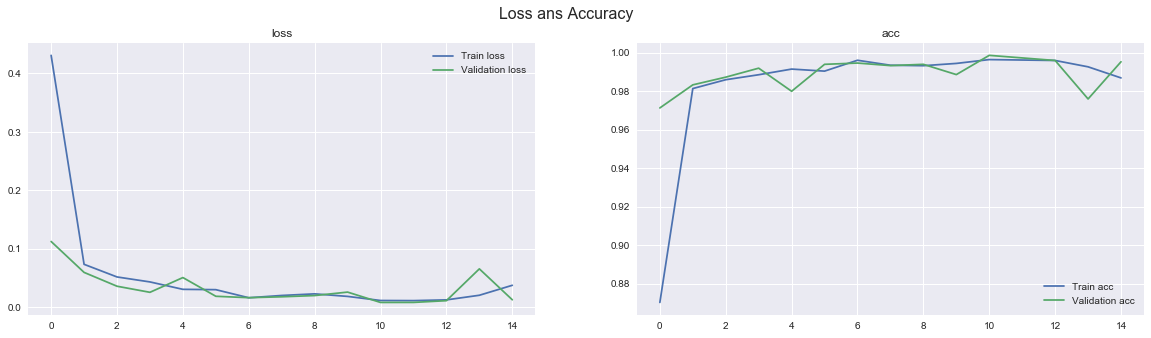

In [72]:
# Plot trainig history
import matplotlib.pyplot as plt

plt.style.use('seaborn')
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
ax[0].legend()
ax[1].legend();
fig.suptitle("Loss ans Accuracy ", fontsize=16)
plt.show();

# Run Finger Counter via Webcam

In [13]:
# Load pretrained model
model = load_model(os.path.join('checkpoint', 'Myemojinator.h5'))

def keras_predict(model, image):
    processed = keras_process_image(image)
    pred_probab = model.predict(processed)[0]
    pred_class = list(pred_probab).index(max(pred_probab))
    return max(pred_probab), pred_class

def keras_process_image(img):
    image_x = 50
    image_y = 50
    img = cv2.resize(img, (image_x, image_y))
    img = np.array(img, dtype=np.float32)
    img = np.reshape(img, (-1, image_x, image_y, 1))
    return img

def get_emojis():
    emojis_folder = 'hand_emo/'
    emojis = []
    for emoji in range(len(os.listdir(emojis_folder))):
        emojis.append(cv2.imread(emojis_folder+str(emoji)+'.png', -1))
    return emojis

def overlay(image, emoji, x,y,w,h):
    emoji = cv2.resize(emoji, (w, h))
    try:
        image[y:y+h, x:x+w] = blend_transparent(image[y:y+h, x:x+w], emoji)
    except:
        pass
    return image

def blend_transparent(face_img, overlay_t_img):
    # Split out the transparency mask from the colour info
    overlay_img = overlay_t_img[:,:,:3] # Grab the BRG planes
    overlay_mask = overlay_t_img[:,:,3:]  # And the alpha plane

    # Again calculate the inverse mask
    background_mask = 255 - overlay_mask

    # Turn the masks into three channel, so we can use them as weights
    overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
    background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

    # Create a masked out face image, and masked out overlay
    # We convert the images to floating point in range 0.0 - 1.0
    face_part = (face_img * (1 / 255.0)) * (background_mask * (1 / 255.0))
    overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))

    # And finally just add them together, and rescale it back to an 8bit integer image
    return np.uint8(cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0))


In [28]:
# Testing the program

def runFingerCounter():
    emojis = get_emojis()
    cap = cv2.VideoCapture(0)
    x, y, w, h = 300, 50, 350, 350

    while (cap.isOpened()):
        ret, img = cap.read()
        img = cv2.flip(img, 1)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        mask2 = cv2.inRange(hsv, np.array([2, 50, 60]), np.array([25, 150, 255]))
        res = cv2.bitwise_and(img, img, mask=mask2)
        gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
        median = cv2.GaussianBlur(gray, (5, 5), 0)

        kernel_square = np.ones((5, 5), np.uint8)
        dilation = cv2.dilate(median, kernel_square, iterations=2)
        opening = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel_square)
        ret, thresh = cv2.threshold(opening, 30, 255, cv2.THRESH_BINARY)

        thresh = thresh[y:y + h, x:x + w]
        contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[1]
        if len(contours) > 0:
            contour = max(contours, key=cv2.contourArea)
            if cv2.contourArea(contour) > 2500:
                x, y, w1, h1 = cv2.boundingRect(contour)
                newImage = thresh[y:y + h1, x:x + w1]
                newImage = cv2.resize(newImage, (50, 50))
                pred_probab, pred_class = keras_predict(model, newImage)
                print(pred_class, pred_probab)
                img = overlay(img, emojis[pred_class], 400, 250, 90, 90)

        # Draw a rectangle: img, pt1, pt2, color, thickness
        x, y, w, h = 300, 50, 350, 350
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.imshow("Frame", img)
        cv2.imshow("Contours", thresh)
        k = cv2.waitKey(10)
        if k == 27:
            cv2.destroyAllWindows()
            break

In [29]:
runFingerCounter()

3 0.9979145
0 0.9951682
0 1.0
0 1.0
0 0.9999999
0 1.0
0 1.0
0 1.0
0 1.0
0 0.9999831
0 0.9999999
0 0.9999987
0 0.999998
0 0.9999994
0 0.99999964
0 0.99999654
0 0.99999857
0 0.9999975
0 0.999998
0 0.99999857
0 0.9999982
0 0.9999962
0 0.9999782
0 0.99999464
0 0.9999989
0 0.9999665
0 0.9998802
0 0.9954417
0 0.99922884
0 0.99422765
0 0.9913173
0 0.9795467
0 0.9942609
0 0.9958192
0 0.99429214
0 0.99930024
0 0.98920476
0 0.9989047
0 0.98914707
0 0.9990852
0 0.994921
0 0.99102473
0 0.9943762
0 0.9932627
0 0.9943241
0 0.9030039
0 0.98712397
0 0.98909646
0 0.94478583
0 0.9994541
0 0.8854541
0 0.9152755
0 0.9769743
0 0.9914117
0 0.9880178
0 0.9938955
0 0.97984
0 0.9974515
0 0.99855274
0 0.99284405
0 0.99975485
0 0.99965715
0 0.99796534
0 0.9988902
0 0.99999726
0 0.9997913
0 0.82221454
0 0.7963555
1 0.9981541
1 0.9989405
1 0.9860097
1 0.8831857
1 0.7631349
1 0.56932783
2 0.6237586
1 0.95845366
1 0.9041416
1 0.9593564
1 0.99984884
1 0.99991655
1 0.9986546
1 0.999046
1 0.9337173
1 0.99938154
1 0.998